# Dataset Overview

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format  # Формат вывода
pd.options.display.max_columns = 500  # Кол-во отображаемых столбцов
%matplotlib inline

train = pd.read_csv('train.csv').rename(columns=lambda x: x.replace(' ', '_'))
test = pd.read_csv('test.csv').rename(columns=lambda x: x.replace(' ', '_'))
submission = pd.read_csv('sample_submission.csv').rename(columns=lambda x: x.replace(' ', '_'))

## Size of Datasets

In [2]:
# Размеры Datasets
df_shape = pd.DataFrame({
    'Dataset': ['Train', 'Test', 'Submission'],
    'Rows': [train.shape[0], test.shape[0], submission.shape[0]],
    'Columns': [train.shape[1], test.shape[1], submission.shape[1]]})
print(df_shape)
print(f"\n Дубликаты строк: {sum(df.duplicated().sum() for df in [train, test, submission])}")

      Dataset     Rows  Columns
0       Train  1200000       21
1        Test   800000       20
2  Submission   800000        2

 Дубликаты строк: 0


## Column Types

In [3]:
dtypes_df = pd.DataFrame({'Train': train.dtypes, 'Test': test.dtypes})
dtypes_df

,Train,Test
Age,float64,float64
Annual_Income,float64,float64
Credit_Score,float64,float64
Customer_Feedback,object,object
Education_Level,object,object
Exercise_Frequency,object,object
Gender,object,object
Health_Score,float64,float64
Insurance_Duration,float64,float64
Location,object,object


## Missing Values

In [6]:
missing_df = pd.DataFrame({
    'Train': train.isna().sum(),
    'Train (%)': (train.isna().sum() / train.shape[0]) * 100,
    'Test': test.isna().sum(),
    'Test (%)': (test.isna().sum() / test.shape[0]) * 100})
#missing_df[(missing_df['Train'] > 0) | (missing_df['Test'] > 0)]
missing_df

,Train,Train (%),Test,Test (%)
Age,18705,1.56,12489.00,1.56
Annual_Income,44949,3.75,29860.00,3.73
Credit_Score,137882,11.49,91451.00,11.43
Customer_Feedback,77824,6.49,52276.00,6.53
Education_Level,0,0.00,0.00,0.00
Exercise_Frequency,0,0.00,0.00,0.00
Gender,0,0.00,0.00,0.00
Health_Score,74076,6.17,49449.00,6.18
Insurance_Duration,1,0.00,2.00,0.00
Location,0,0.00,0.00,0.00


## Numerical & Categorical Features

In [2]:
# Назначение id в индекс
train = train.set_index('id')
test = test.set_index('id')

# Перевод числовых столбцов в категориальные
train.Number_of_Dependents = train.Number_of_Dependents.astype('object')
train.Previous_Claims = train.Previous_Claims.astype('object')

# Datetime
train.Policy_Start_Date = pd.to_datetime(train.Policy_Start_Date)

target = 'Premium_Amount'
num_cols = train.drop('Premium_Amount', axis=1).select_dtypes(include=np.number).columns.tolist()
cat_cols = train.drop('Policy_Start_Date', axis=1).select_dtypes(exclude=np.number).columns.tolist()
datetime_cols = train.select_dtypes(include='datetime64[ns]').columns.tolist()

print(num_cols)
print(cat_cols)
print(datetime_cols)

['Age', 'Annual_Income', 'Health_Score', 'Vehicle_Age', 'Credit_Score', 'Insurance_Duration']
['Gender', 'Marital_Status', 'Number_of_Dependents', 'Education_Level', 'Occupation', 'Location', 'Policy_Type', 'Previous_Claims', 'Customer_Feedback', 'Smoking_Status', 'Exercise_Frequency', 'Property_Type']
['Policy_Start_Date']


# EDA

## Target Values: Premium Amount

In [7]:
print(f"Кол-во пропусков: {train[target].isnull().sum()}")
train[target].describe().loc[['count', 'mean', 'min', 'max']]

Кол-во пропусков: 0


count   1200000.00
mean       1102.54
min          20.00
max        4999.00
Name: Premium_Amount, dtype: float64

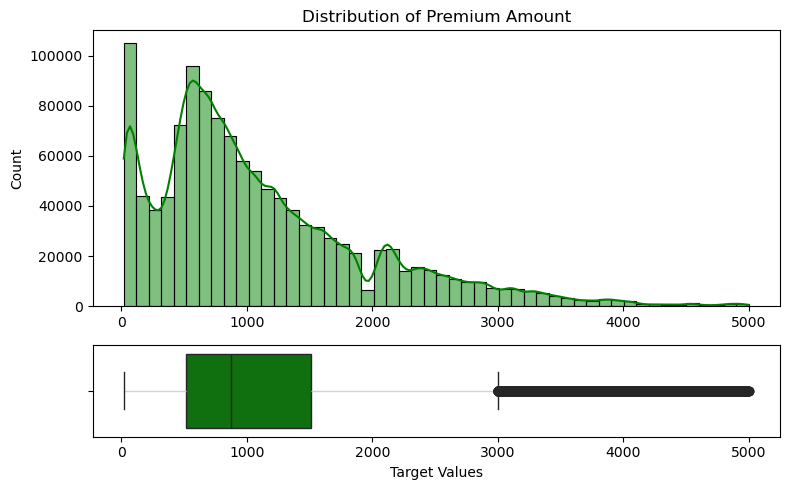

In [10]:
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = plt.subplot(gs[0])
sns.histplot(train[target], kde=True, bins=50, color='green', ax=ax1)
ax1.set_xlabel('')
ax1.set_title("Distribution of Premium Amount")

ax2 = plt.subplot(gs[1], sharex=ax1)
sns.boxplot(x=train[target], color='green', whiskerprops=dict(color='lightgray'), ax=ax2)
ax2.set_xlabel("Target Values")

plt.tight_layout()
plt.show()


## Age  

Средний Premium Amount для возрастной категории 18-24 почти в 2 раза меньше, чем в остальных категориях.

In [3]:
column = 'Age'
print(f"Кол-во пропусков: {train[column].isnull().sum()}")
train[column].describe().loc[['count', 'mean', 'min', 'max']]

Кол-во пропусков: 18705


count   1181295.00
mean         41.15
min          18.00
max          64.00
Name: Age, dtype: float64

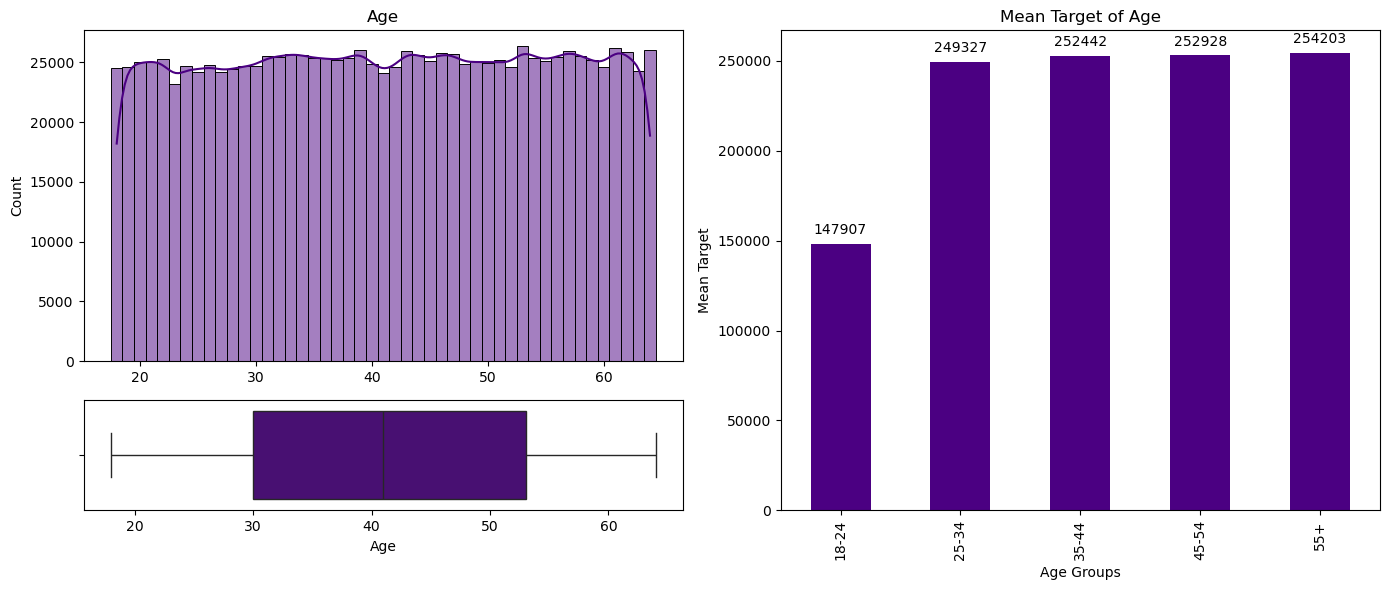

In [4]:
# Разбивка по интервалам возраста
age_bins = [18, 24, 34, 44, 54, float('inf')]
age_labels = ['18-24', '25-34', '35-44', '45-54', '55+']
train[f'Groups_{column}'] = pd.cut(train[column], bins=age_bins, labels=age_labels, right=True)

# Создание сетки с 2 столбцами и 2 строками
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[1, 1])  # Пропорции для строк: 3/4 и 1/4

# График 1: Гистограмма с KDE
ax1 = plt.subplot(gs[0, 0])
sns.histplot(train[column], kde=True, discrete=True, color='indigo', ax=ax1)
ax1.set_xlabel('')
ax1.set_title(column)

# График 2: Боксплот
ax2 = plt.subplot(gs[1, 0])
sns.boxplot(x=train[column], color='indigo', ax=ax2)
ax2.set_xlabel(column)

# График 3: Столбчатая диаграмма по возрастным группам
ax3 = plt.subplot(gs[:, 1])
age_group_counts = train[f'Groups_{column}'].value_counts().sort_index()
age_group_counts.plot(kind='bar', color='indigo', ax=ax3)

bars = ax3.containers[0]
ax3.bar_label(bars, labels=[round(v, 2) for v in age_group_counts], padding=5)

ax3.set_title(f'Mean Target of {column}')
ax3.set_xlabel(f'{column} Groups')
ax3.set_ylabel('Mean Target')

plt.tight_layout()
plt.show()
train.drop(columns=[f'Groups_{column}'], inplace=True)

## Distribition Age of Categorical Features  

Медианное значение Age для всех категориальных столбцов равна 41.00

In [5]:
cat_cols

['Gender',
 'Marital_Status',
 'Number_of_Dependents',
 'Education_Level',
 'Occupation',
 'Location',
 'Policy_Type',
 'Previous_Claims',
 'Customer_Feedback',
 'Smoking_Status',
 'Exercise_Frequency',
 'Property_Type']

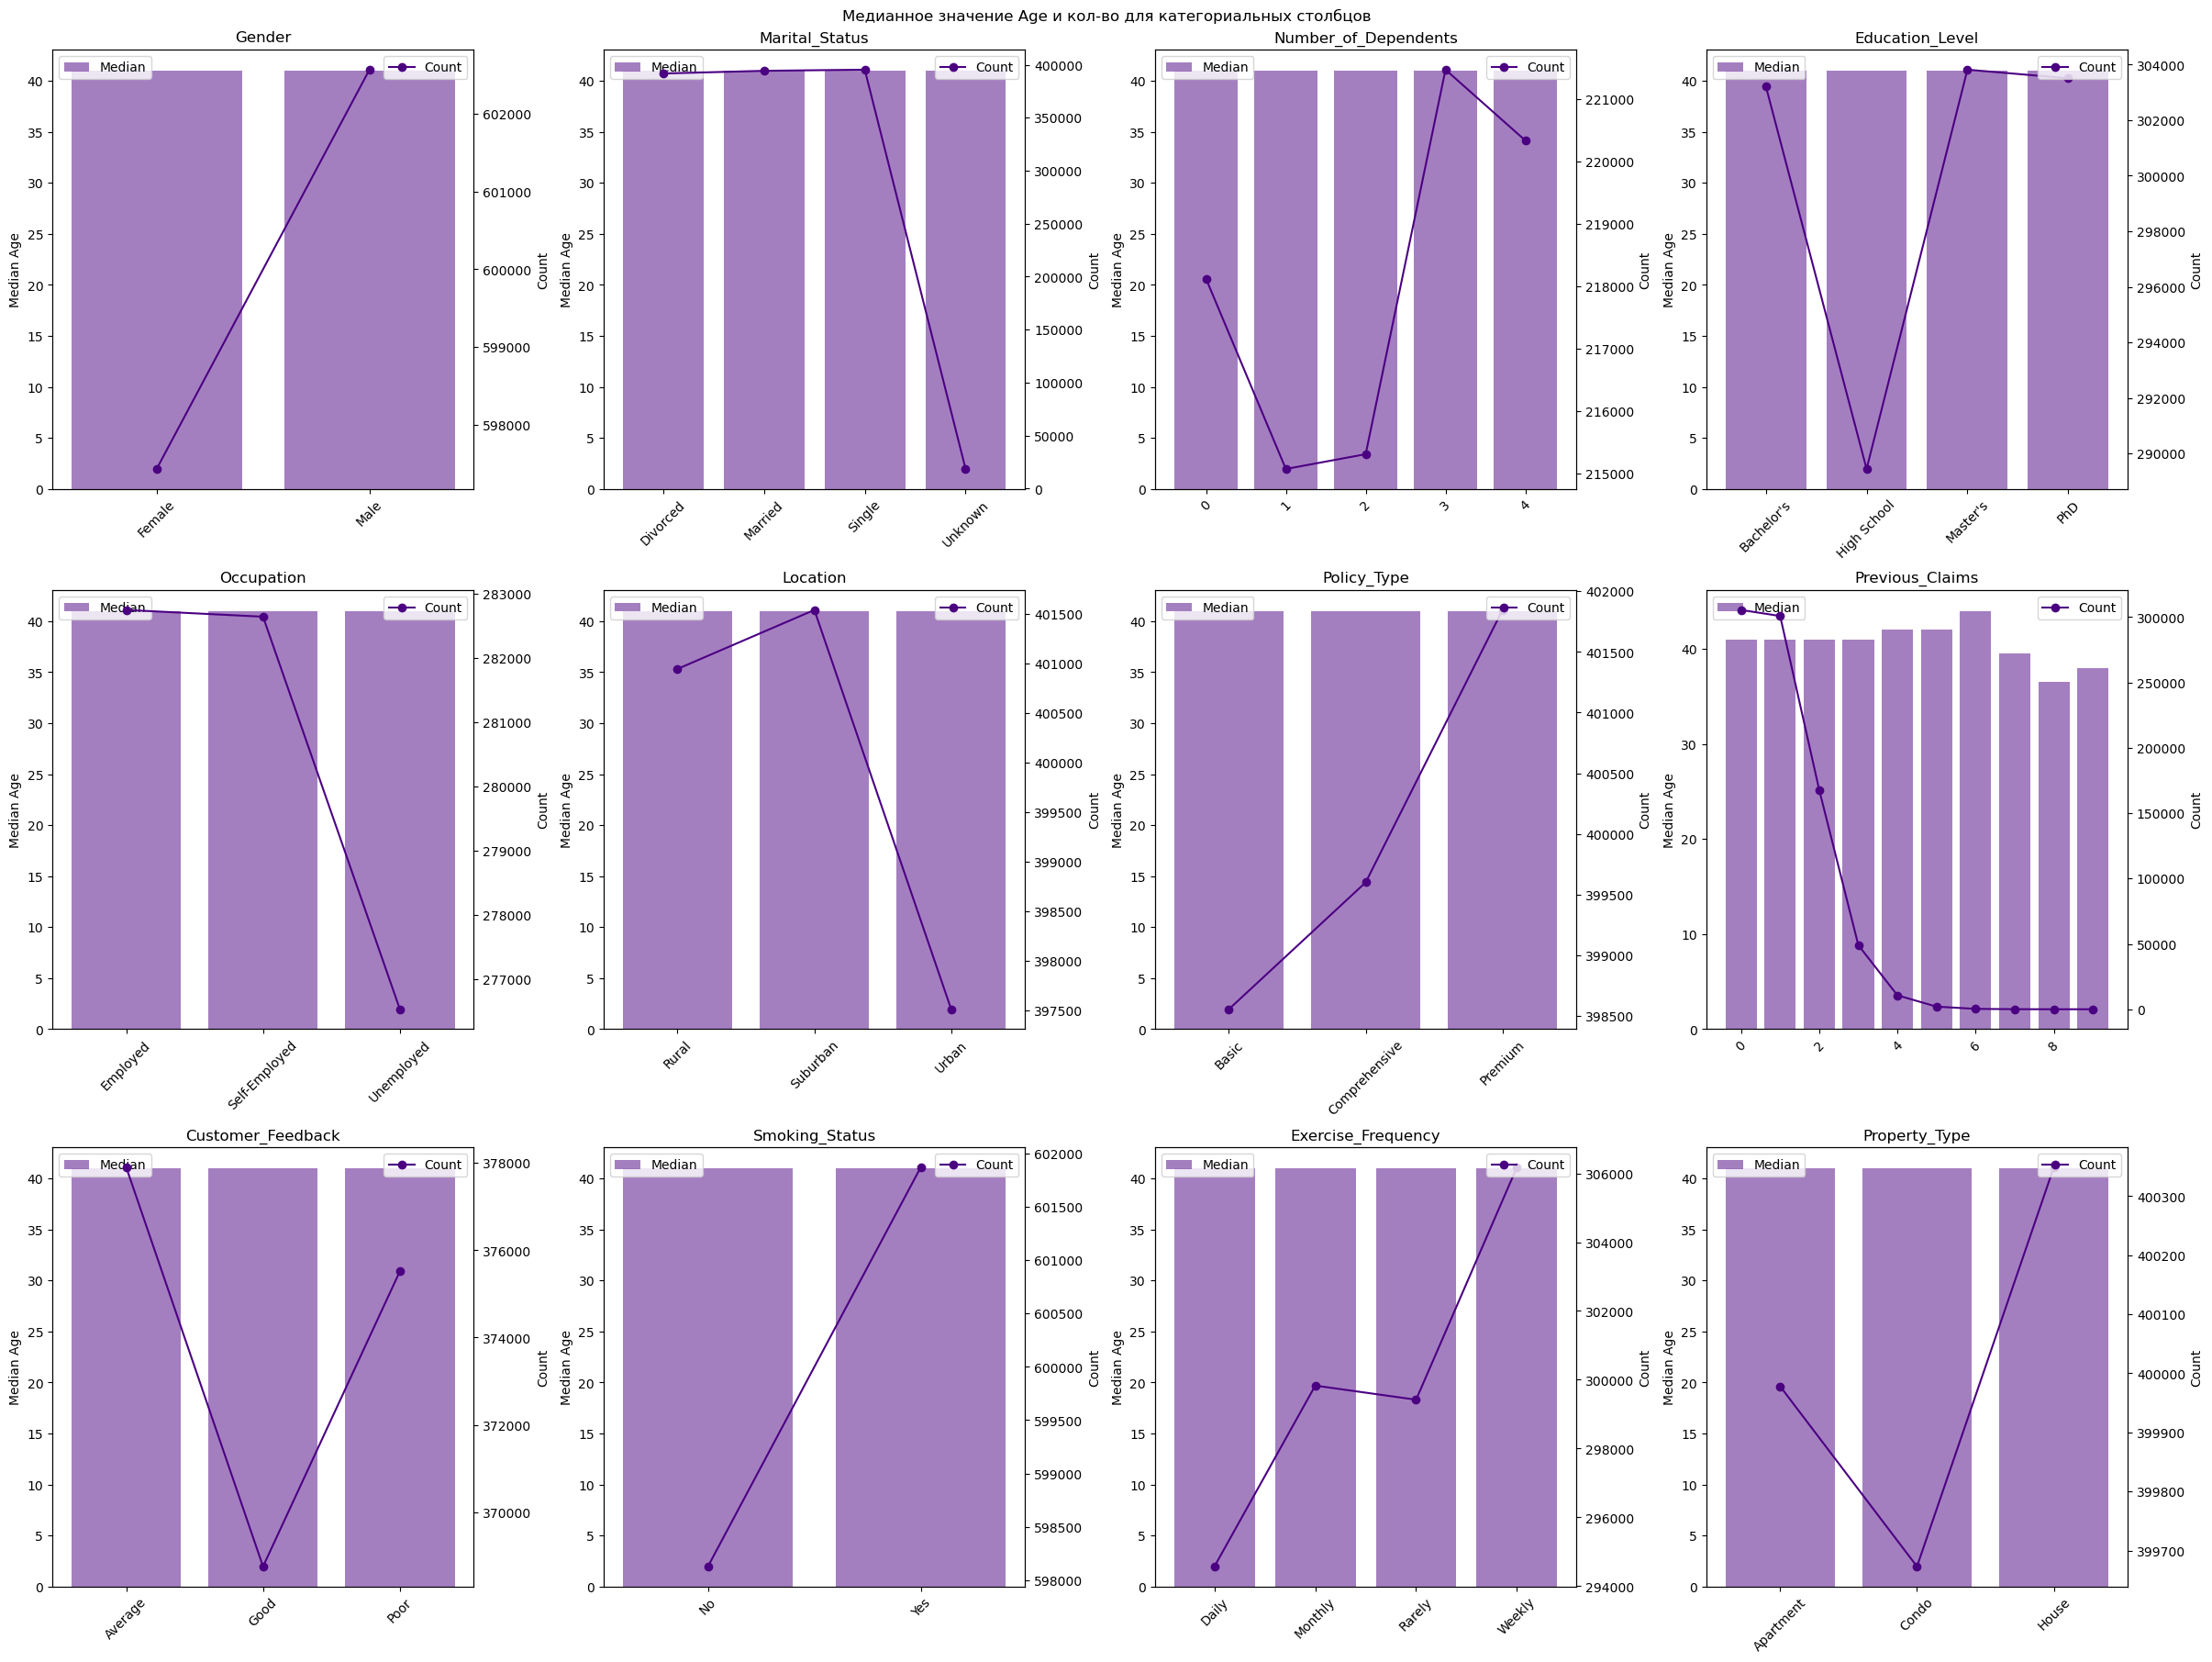

In [15]:
n_cols = 4  # Количество столбцов
n_rows = (len(cat_cols) + n_cols - 1) // n_cols  # Расчет необходимого количества строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Преобразуем оси в одномерный список для удобного доступа
fig.suptitle(f'Медианное значение {column} и кол-во для категориальных столбцов')

for i, col in enumerate(cat_cols):
    ax1 = axes[i]  # Текущая ось для медианы
    ax2 = ax1.twinx()  # Вторая ось для количества

    group_median = train.groupby(col)[column].median().sort_index()
    group_count = train[col].value_counts().sort_index()

    # Столбчатая диаграмма медианного возраста
    ax1.bar(group_median.index, group_median, color='indigo', alpha=0.5, label='Median')
    ax1.set_ylabel(f'Median {column}')
    ax1.tick_params(axis='y')
    ax1.set_title(f'{col}')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(loc='upper left')

    # Линейный график распределения количества
    ax2.plot(group_count.index, group_count, color='indigo', marker='o', label='Count')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper right')
    
# Очищаем оставшиеся пустые оси (если графиков меньше, чем ячеек)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


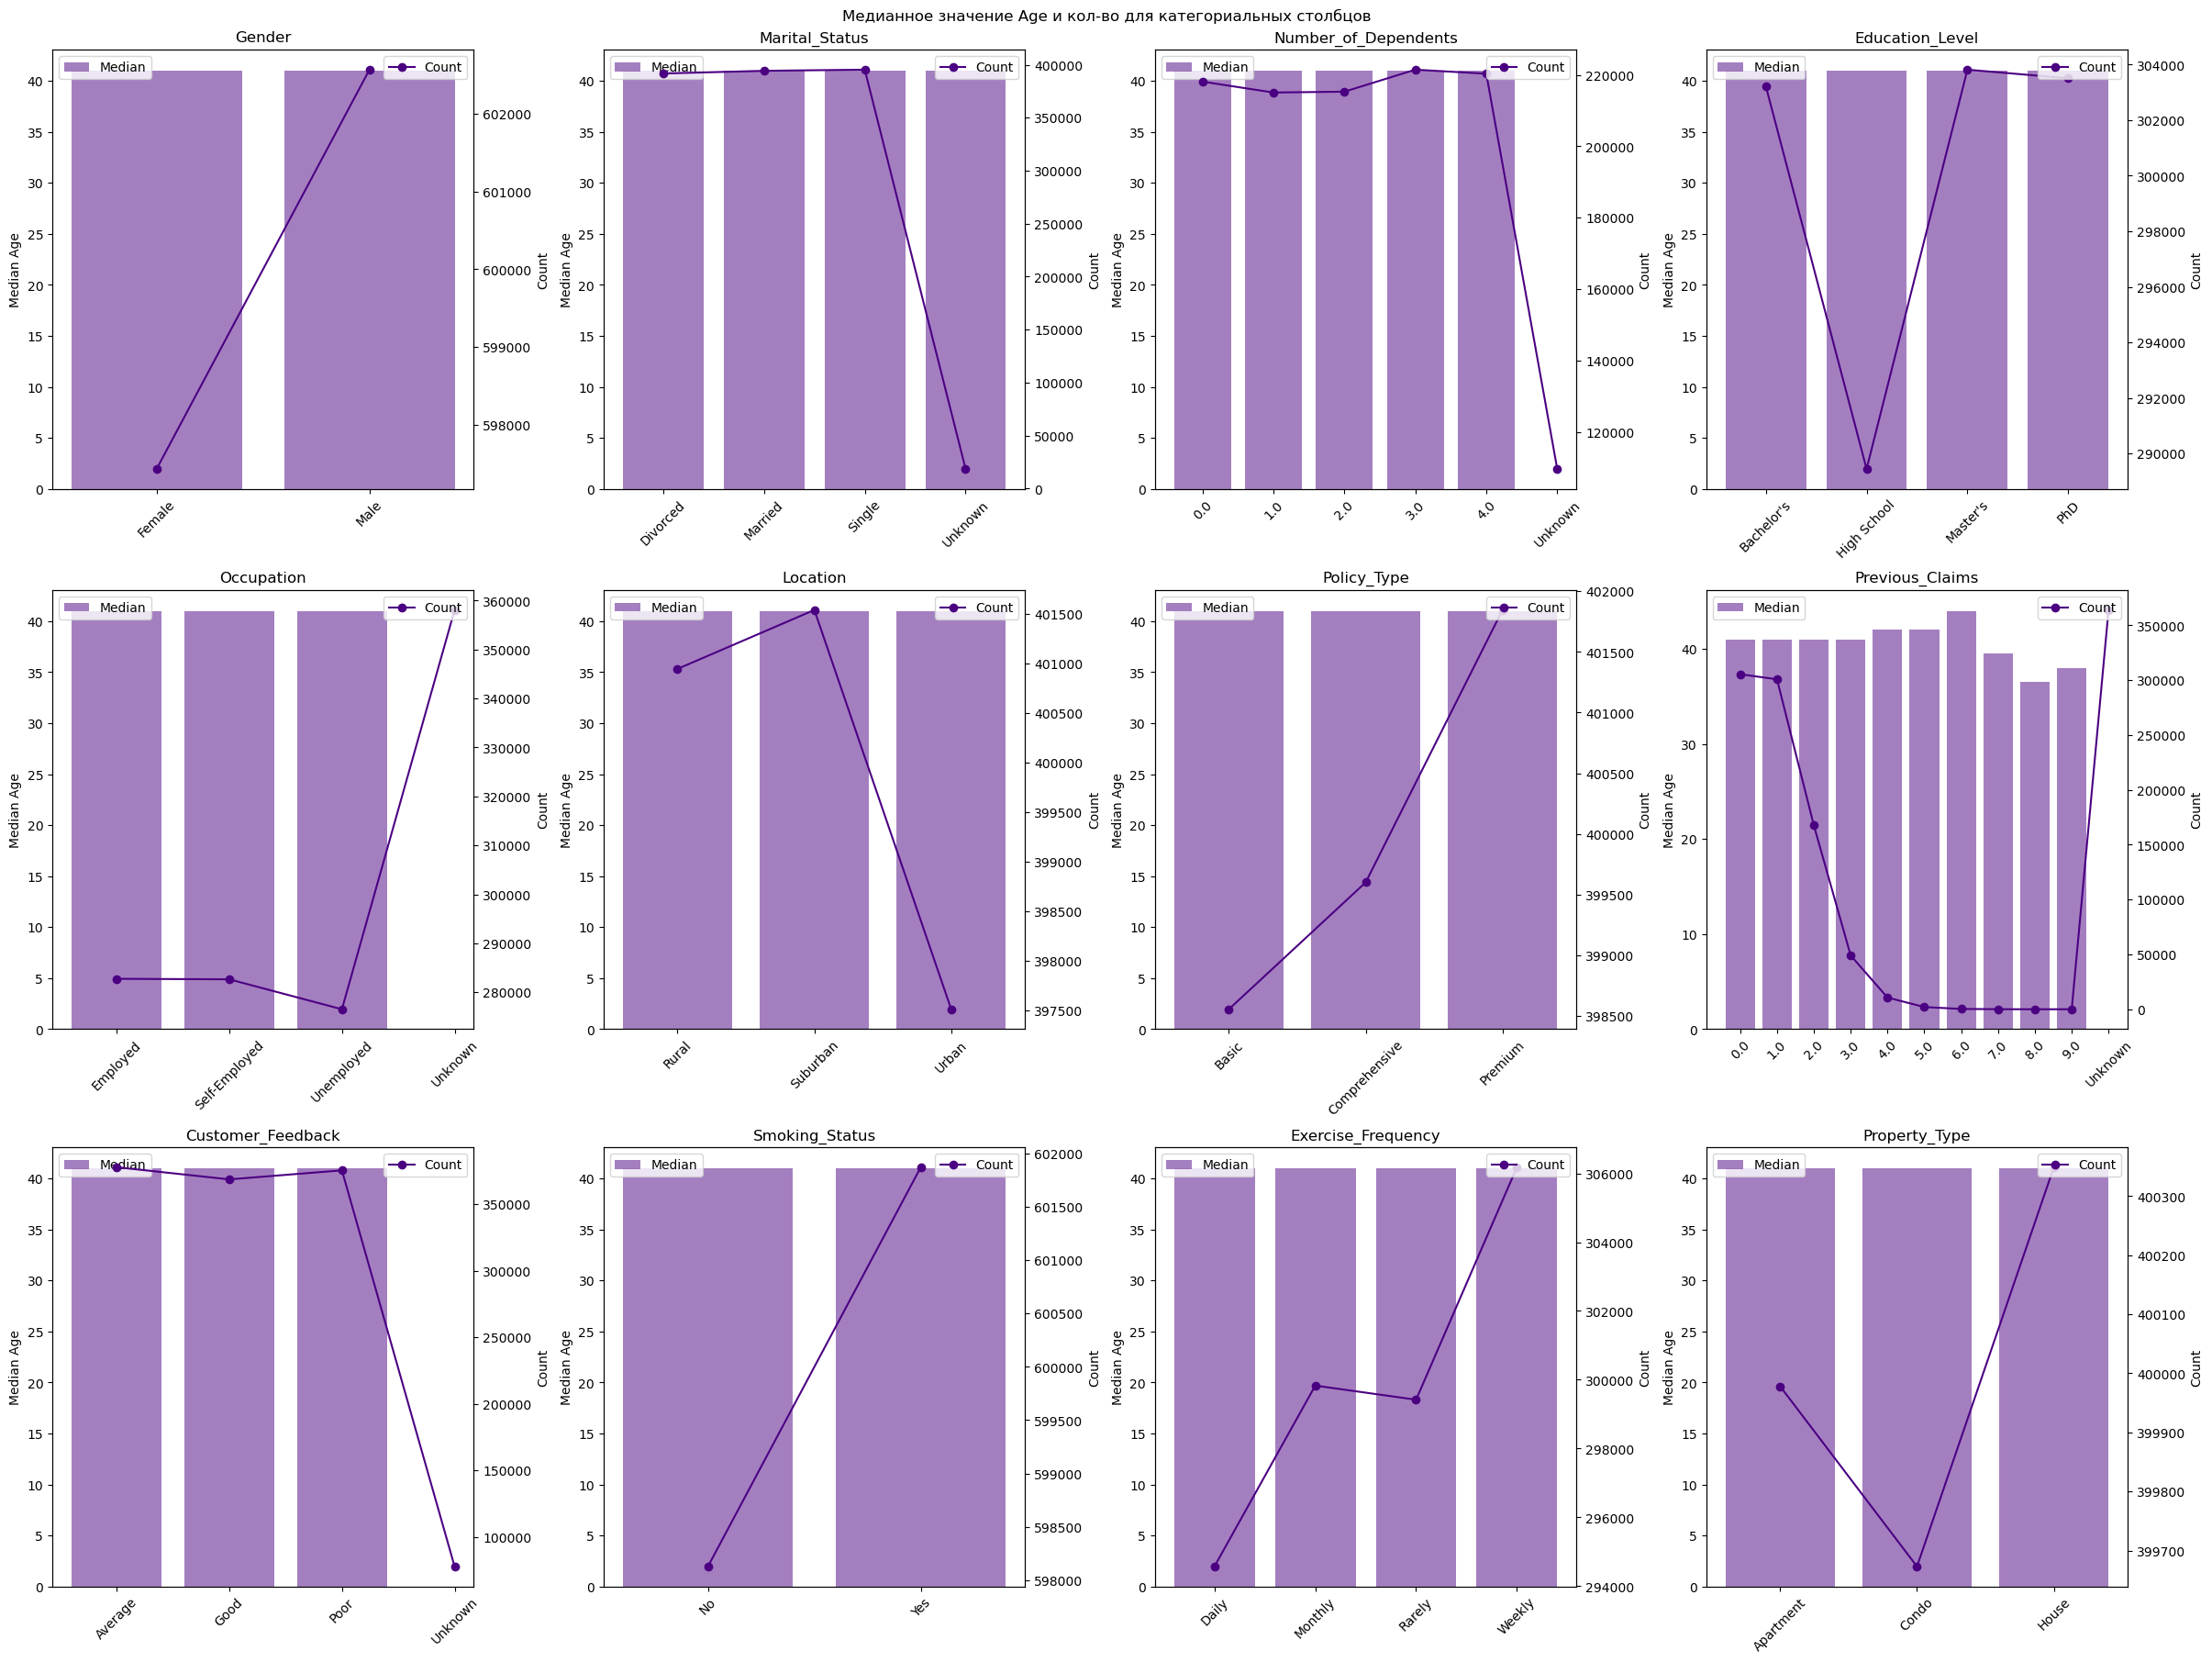

In [17]:
n_cols = 4  # Количество столбцов
n_rows = (len(cat_cols) + n_cols - 1) // n_cols  # Расчет необходимого количества строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Преобразуем оси в одномерный список для удобного доступа
fig.suptitle(f'Медианное значение {column} и кол-во для категориальных столбцов')

for i, col in enumerate(cat_cols):
    ax1 = axes[i]  # Текущая ось для медианы
    ax2 = ax1.twinx()  # Вторая ось для количества

    # Столбчатая диаграмма медианного возраста
    group_median = train.groupby(col)[column].median().sort_index()
    ax1.bar(group_median.index, group_median, color='indigo', alpha=0.5, label='Median')
    ax1.set_ylabel(f'Median {column}')
    ax1.tick_params(axis='y')
    ax1.set_title(f'{col}')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(loc='upper left')


    # Линейный график распределения количества
    train_temp = train.copy()  # Создаем копию датафрейма
    train_temp[col] = train_temp[col].fillna('Unknown')  # Заполняем пропуски в копии
    group_count = train_temp[col].astype(str).value_counts().sort_index()
    ax2.plot(group_count.index, group_count, color='indigo', marker='o', label='Count')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper right')
    
# Очищаем оставшиеся пустые оси (если графиков меньше, чем ячеек)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


## Distribition Age of Numerical Features  



In [18]:
num_cols

['Age',
 'Annual_Income',
 'Health_Score',
 'Vehicle_Age',
 'Credit_Score',
 'Insurance_Duration']

AttributeError: 'Axes' object has no attribute 'countplot'

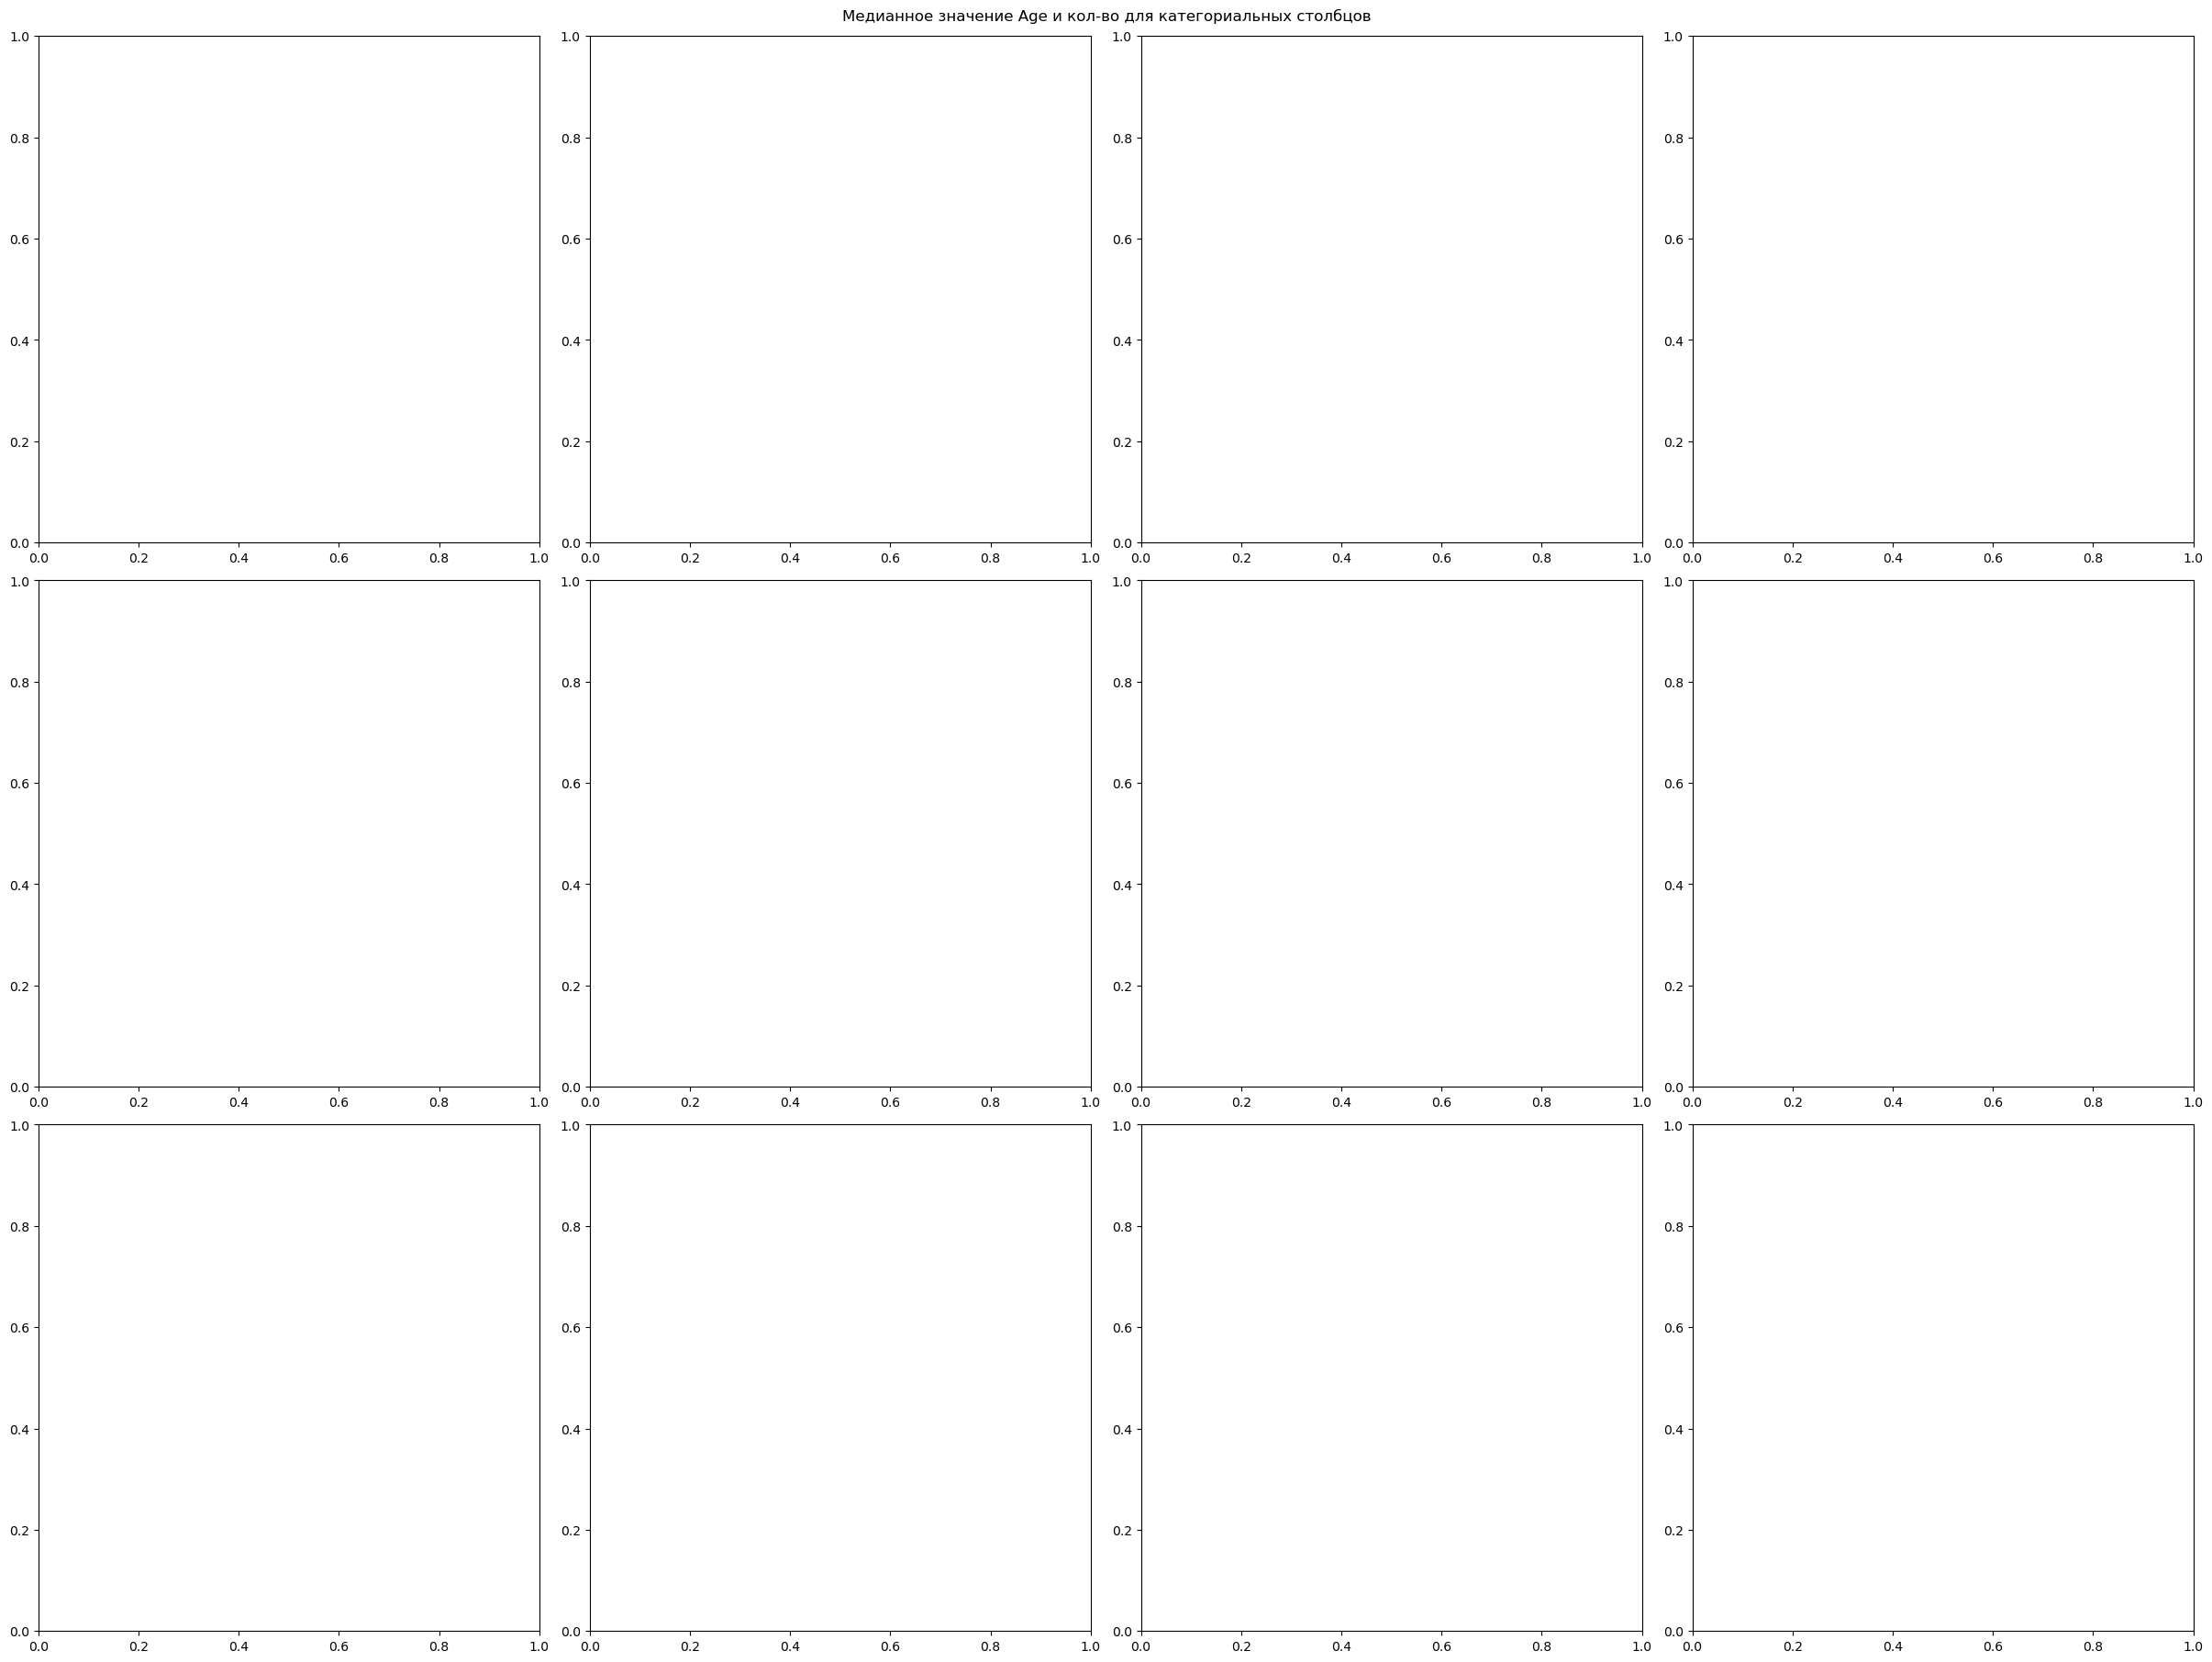

In [24]:
n_cols = 4  # Количество столбцов
n_rows = (len(cat_cols) + n_cols - 1) // n_cols  # Расчет необходимого количества строк

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Преобразуем оси в одномерный список для удобного доступа
fig.suptitle(f'Медианное значение {column} и кол-во для категориальных столбцов')

for i, col in enumerate(cat_cols):
    ax1 = axes[i]  # Текущая ось для медианы
    ax1.plo
    ax1.countplot(x=pd.cut(train[col], bins=3), y='Age', data=train, color='indigo', ci=None)
    
# Очищаем оставшиеся пустые оси (если графиков меньше, чем ячеек)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


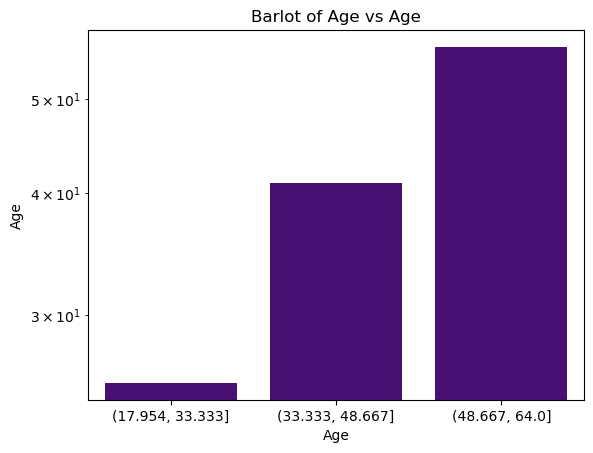

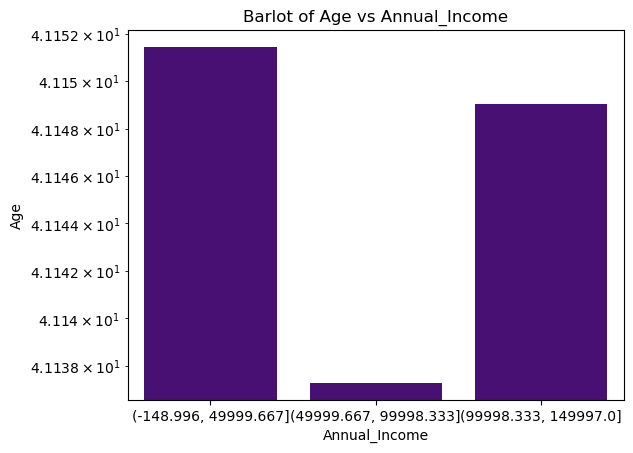

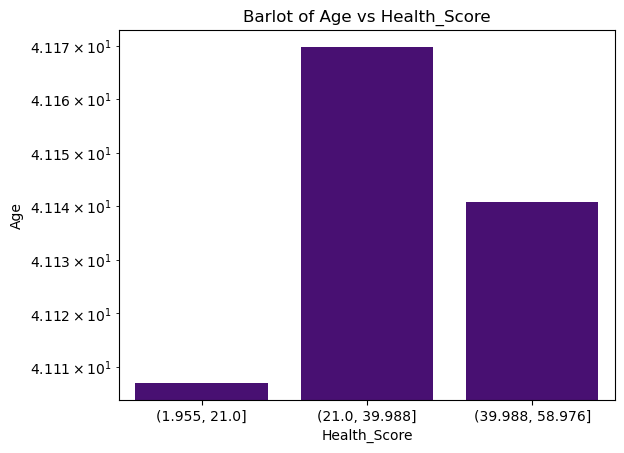

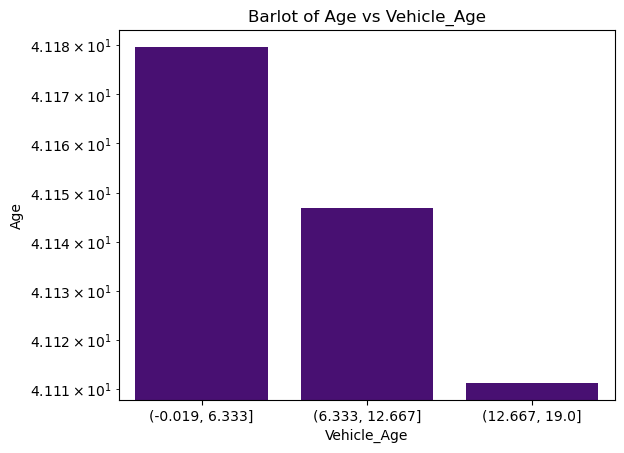

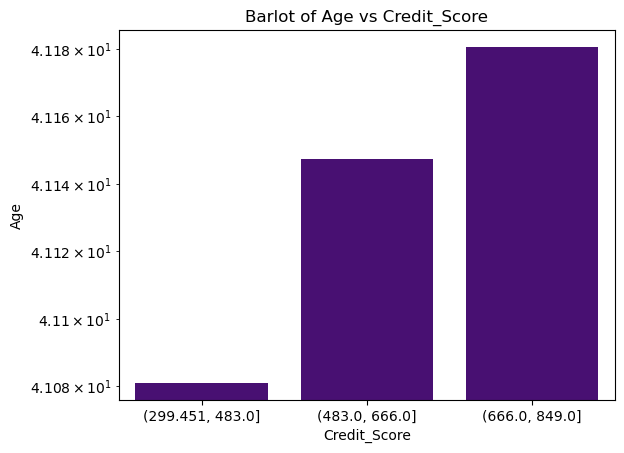

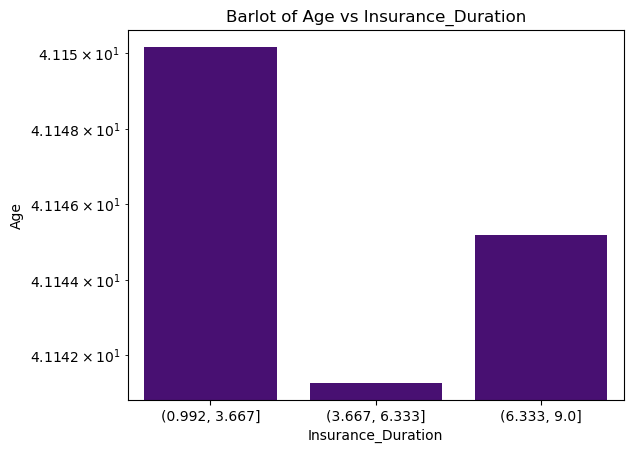

In [19]:
for col in num_cols:
    sns.barplot(x=pd.cut(train[col], bins=3), y='Age', data=train, color='indigo', ci=None)
    plt.title(f'Barlot of Age vs {col}')
    plt.xlabel(f'{col}')
    plt.yscale('log')
    plt.show()

In [ ]:
for col in num_cols:
    train['Binned'] = pd.cut(train[col], bins=3) 
    sns.barplot(x='Binned', y='Age', data=train, color='indigo', ci=None)
    plt.title(f'Barlot of Age vs {col}')
    plt.xlabel(f'{col}')
    plt.yscale('log')
    plt.show()

In [ ]:
train['Binned'] = pd.cut(train.Credit_Score, bins=3)
train['Binned'].value_counts().sort_index()
sns.barplot(x='Binned', y='Age', data=train, color='indigo', ci=None)
plt.show()

In [ ]:
mean_age_per_bin = train.groupby('Binned')['Age'].mean()
print(mean_age_per_bin)

In [ ]:
train['BinnedFeature'] = pd.cut(train['Annual_Income'], bins=20)  # разбиение на группы
sns.barplot(x='BinnedFeature', y='Age', data=train)
plt.title('Boxplot of Age vs Binned Feature1')
plt.ylim(40)
plt.show()